[View in Colaboratory](https://colab.research.google.com/github/korrawe/exxon_training/blob/master/Lab_regression.ipynb)

# Regression
In this lab, we will redefine out problem as the regression problem, specifically, how many year an employee will stay in the company.

## Import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier, plot_tree, plot_importance, XGBRegressor

from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 15,15

In [0]:
from google.colab import files
import io 

# uploaded = files.upload()

### Define target encode function

In [0]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index

    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## Loadin data

In [0]:
df = pd.read_csv('data.csv')

To reasonably train a regression model, we can use only the data from employees that have already left the company as the employees who are still working for the company might stay in the company for a few years. We will also not consider employees who stay in the company less than one year since their information are usually blank

In [5]:
df[df['WorkDurationYear'] == 0].head()

,SerialNumber,Leave,ActionYear,WorkDurationYear,CountLoan,Avg_MonthPerLoan,HireType,HireSourceGroup,WorkDurationYear.1,Avg_TotalAbsensePerYear,Avg_NumDaysPerAbsense,TotalEduAllowance,NumYear_SinceLastEduAllowance,TotalEduAttend,EduBranch_CHEM,EduBranch_Finance,EduBranch_Languages,Max_EduInstituteGroup,NumYear_SinceLastEdu
953,1268,0.0,2013,0.0,1.0,49.0,Experienced Hire,Referral,0.0,0.0,1.160305,0.0,0.0,0.0,0.0,1.0,0.0,UNIV,16.0
1341,1789,1.0,2000,0.0,0.0,0.0,Unknown,Unknown,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,OTHR,1.0
1351,1799,0.0,2000,0.0,0.0,0.0,Unknown,Unknown,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,INST,2.0
1367,1815,1.0,2000,0.0,0.0,0.0,Unknown,Unknown,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,UNIV,5.0
1370,1818,1.0,2000,0.0,0.0,0.0,Unknown,Unknown,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,UNIV,2.0


In [0]:
df_left = df.loc[(df['Leave'] == 1) & (df['WorkDurationYear'] > 0)].reset_index()

In [7]:
df_left.describe()

,index,SerialNumber,Leave,ActionYear,WorkDurationYear,CountLoan,Avg_MonthPerLoan,WorkDurationYear.1,Avg_TotalAbsensePerYear,Avg_NumDaysPerAbsense,TotalEduAllowance,NumYear_SinceLastEduAllowance,TotalEduAttend,EduBranch_CHEM,EduBranch_Finance,EduBranch_Languages,NumYear_SinceLastEdu
count,2155.000000,2155.000000,2155.0,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,1986.693271,2366.535963,1.0,2008.880742,8.292807,0.193503,6.784068,8.292807,3.294308,1.125274,0.320650,0.275638,0.141995,0.014385,0.266821,0.096056,10.025058
std,1171.968416,1269.639646,0.0,5.182212,9.071987,0.446959,19.514586,9.071987,4.015256,1.946174,1.031408,1.025730,0.373538,0.119100,0.442401,0.294736,10.775386
min,0.000000,4.000000,1.0,2000.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1070.000000,1433.500000,1.0,2005.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,1994.000000,2442.000000,1.0,2009.000000,5.000000,0.000000,0.000000,5.000000,2.000000,1.093023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2958.500000,3406.500000,1.0,2013.000000,10.500000,0.000000,0.000000,10.500000,5.666667,1.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000
max,4328.000000,4776.000000,1.0,2017.000000,41.000000,3.000000,171.000000,41.000000,41.000000,45.000000,7.000000,14.000000,4.000000,1.000000,1.000000,1.000000,48.000000


In [8]:
dfEduInstituteGroup = pd.get_dummies(df_left['Max_EduInstituteGroup'], prefix='Max_EduInstituteGroup')
dfHireTypeGroup = pd.get_dummies(df_left['HireType'], prefix='HireType')
dfHireSourceGroup = pd.get_dummies(df_left['HireSourceGroup'], prefix='HireSourceGroup')

df_left = pd.concat([df_left, dfEduInstituteGroup,dfHireTypeGroup,dfHireSourceGroup], axis=1)
df_left.columns.values

array(['index', 'SerialNumber', 'Leave', 'ActionYear', 'WorkDurationYear',
       'CountLoan', 'Avg_MonthPerLoan', 'HireType', 'HireSourceGroup',
       'WorkDurationYear.1', 'Avg_TotalAbsensePerYear',
       'Avg_NumDaysPerAbsense', 'TotalEduAllowance',
       'NumYear_SinceLastEduAllowance', 'TotalEduAttend',
       'EduBranch_CHEM', 'EduBranch_Finance', 'EduBranch_Languages',
       'Max_EduInstituteGroup', 'NumYear_SinceLastEdu',
       'Max_EduInstituteGroup_ACAD', 'Max_EduInstituteGroup_CAMP',
       'Max_EduInstituteGroup_COLL', 'Max_EduInstituteGroup_INST',
       'Max_EduInstituteGroup_NIDA', 'Max_EduInstituteGroup_OTHR',
       'Max_EduInstituteGroup_SASI', 'Max_EduInstituteGroup_SCHL',
       'Max_EduInstituteGroup_UNIV', 'Max_EduInstituteGroup_Unknown',
       'HireType_Contractor Conversion', 'HireType_Experienced Hire',
       'HireType_Inexperienced Hire', 'HireType_Unknown',
       'HireSourceGroup_Agency', 'HireSourceGroup_Campus/Fair',
       'HireSourceGroup_Contract

In [0]:
# Remove space from column names because graphviz will throw an error when receive column name with space
rename_col = {
    'HireType_Contractor Conversion':'HireType_ContractorConversion',
    'HireType_Experienced Hire':'HireType_ExperiencedHire',
    'HireType_Inexperienced Hire':'HireType_InexperiencedHire'
}

df_left = df_left.rename(rename_col, axis=1)

In [0]:
# We will drop 'WorkDurationYear' and 'NumYear_SinceLastEdu' too as it captures information that can be used to directly infer 'WorkDurationYear'
df_variable = df_left.drop(['SerialNumber','ActionYear','Leave', 'WorkDurationYear', 'WorkDurationYear.1', 'index', 'NumYear_SinceLastEdu'], axis=1)
df_label = df_left['WorkDurationYear']

X_train, X_test, y_train, y_test = train_test_split(df_variable, df_label, test_size=0.20, random_state=101)

In [11]:
X_train.head()

,CountLoan,Avg_MonthPerLoan,HireType,HireSourceGroup,Avg_TotalAbsensePerYear,Avg_NumDaysPerAbsense,TotalEduAllowance,NumYear_SinceLastEduAllowance,TotalEduAttend,EduBranch_CHEM,...,HireType_ExperiencedHire,HireType_InexperiencedHire,HireType_Unknown,HireSourceGroup_Agency,HireSourceGroup_Campus/Fair,HireSourceGroup_Contractor Conversion,HireSourceGroup_Other,HireSourceGroup_Referral,HireSourceGroup_Unknown,HireSourceGroup_Website/Ads
759,0.0,0.0,Unknown,Unknown,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1837,0.0,0.0,Inexperienced Hire,Website/Ads,1.000000,1.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1926,0.0,0.0,Inexperienced Hire,Campus/Fair,4.200000,1.809524,3.0,1.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
1293,0.0,0.0,Unknown,Unknown,9.714286,1.308824,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2089,0.0,0.0,Inexperienced Hire,Agency,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0


In [0]:
# Create new dataframe with rows in train and test set
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

In [0]:
col_names_cat = ['HireType', 'HireSourceGroup', 'Max_EduInstituteGroup']

In [0]:
# Target encode these categorical features in our data
for f in col_names_cat:
    X_train[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                              trn_series=X_train[f],
                                              tst_series=X_test[f],
                                              target=y_train,
                                              min_samples_leaf=200,
                                              smoothing=10,
                                              noise_level=0
                                              )

In [15]:
X_train.head()

,CountLoan,Avg_MonthPerLoan,HireType,HireSourceGroup,Avg_TotalAbsensePerYear,Avg_NumDaysPerAbsense,TotalEduAllowance,NumYear_SinceLastEduAllowance,TotalEduAttend,EduBranch_CHEM,...,HireSourceGroup_Agency,HireSourceGroup_Campus/Fair,HireSourceGroup_Contractor Conversion,HireSourceGroup_Other,HireSourceGroup_Referral,HireSourceGroup_Unknown,HireSourceGroup_Website/Ads,HireType_avg,HireSourceGroup_avg,Max_EduInstituteGroup_avg
759,0.0,0.0,Unknown,Unknown,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,11.607109,11.599808,19.314623
1837,0.0,0.0,Inexperienced Hire,Website/Ads,1.000000,1.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,3.026316,8.290601,5.477577
1926,0.0,0.0,Inexperienced Hire,Campus/Fair,4.200000,1.809524,3.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,3.026316,8.290596,5.477577
1293,0.0,0.0,Unknown,Unknown,9.714286,1.308824,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,11.607109,11.599808,5.477577
2089,0.0,0.0,Inexperienced Hire,Agency,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,3.026316,3.075036,5.477577


In [0]:
X_train = X_train.drop(['Max_EduInstituteGroup','HireType','HireSourceGroup'], axis=1)
X_test = X_test.drop(['Max_EduInstituteGroup','HireType','HireSourceGroup'], axis=1)

## Model

In [0]:
# Define XGboost regressor 
model = XGBRegressor(n_estimators=400, 
                     learning_rate=0.07, 
                     gamma=6,
                     reg_alpha=6,
                     reg_lambda=1.0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     max_depth=5)

In [18]:
# Train
model.fit(X_train, y_train)
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=6, learning_rate=0.07, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=6, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


## Evaluation

In [19]:
# Predict test data
predictions = model.predict(X_test)
y_test_np = np.array(y_test)

# Print sample prediction and label
sample_output_size = 5
print('pred\tlabel')
for i in range(sample_output_size):
    print('%.2f\t%.2f' % (predictions[i], y_test_np[i]))

pred	label
12.56	11.00
3.36	2.00
18.91	30.00
14.98	7.00
21.35	11.00


In [20]:
# Do error analysis
# print(explained_variance_score(predictions, y_test))
print('mean absolute error: %f' %mean_absolute_error(predictions, y_test))
print('mean square error: %f' % mean_squared_error(predictions, y_test))

mean absolute error: 4.053988
mean square error: 44.235630


(array([114.,  77.,  48.,  35.,  28.,  20.,  11.,  10.,  11.,   2.,   6.,
          6.,   4.,   9.,   5.,   2.,   6.,   6.,   6.,   4.,   3.,   1.,
          2.,   2.,   0.,   2.,   4.,   1.,   0.,   0.,   1.,   3.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([4.77671623e-04, 7.73142043e-01, 1.54580641e+00, 2.31847079e+00,
        3.09113516e+00, 3.86379953e+00, 4.63646390e+00, 5.40912827e+00,
        6.18179264e+00, 6.95445701e+00, 7.72712138e+00, 8.49978575e+00,
        9.27245013e+00, 1.00451145e+01, 1.08177789e+01, 1.15904432e+01,
        1.23631076e+01, 1.31357720e+01, 1.39084364e+01, 1.46811007e+01,
        1.54537651e+01, 1.62264295e+01, 1.69990938e+01, 1.77717582e+01,
        1.85444226e+01, 1.93170869e+01, 2.00897513e+01, 2.08624157e+01,
        2.16350801e+01, 2.24077444e+01, 2.31804088e+01, 2.39530732e+01,
        2.47257375e+01, 2.54984019e+01, 2.62710663e+01, 2.70437307e+01,
        2.78163950e+01, 2.85890594e+01, 2.93617238e+01, 3.01343881e+01,
      

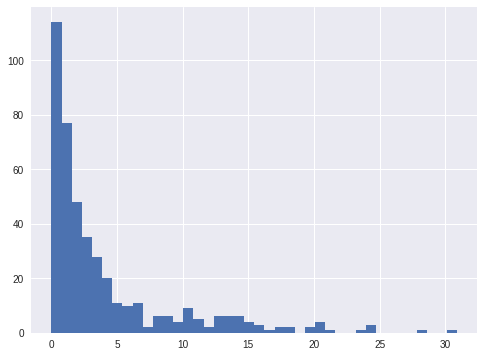

In [21]:
# plot distribution of error
error = np.abs(predictions - y_test)
plt.figure(figsize=(8,6))
plt.hist(error, bins=40)

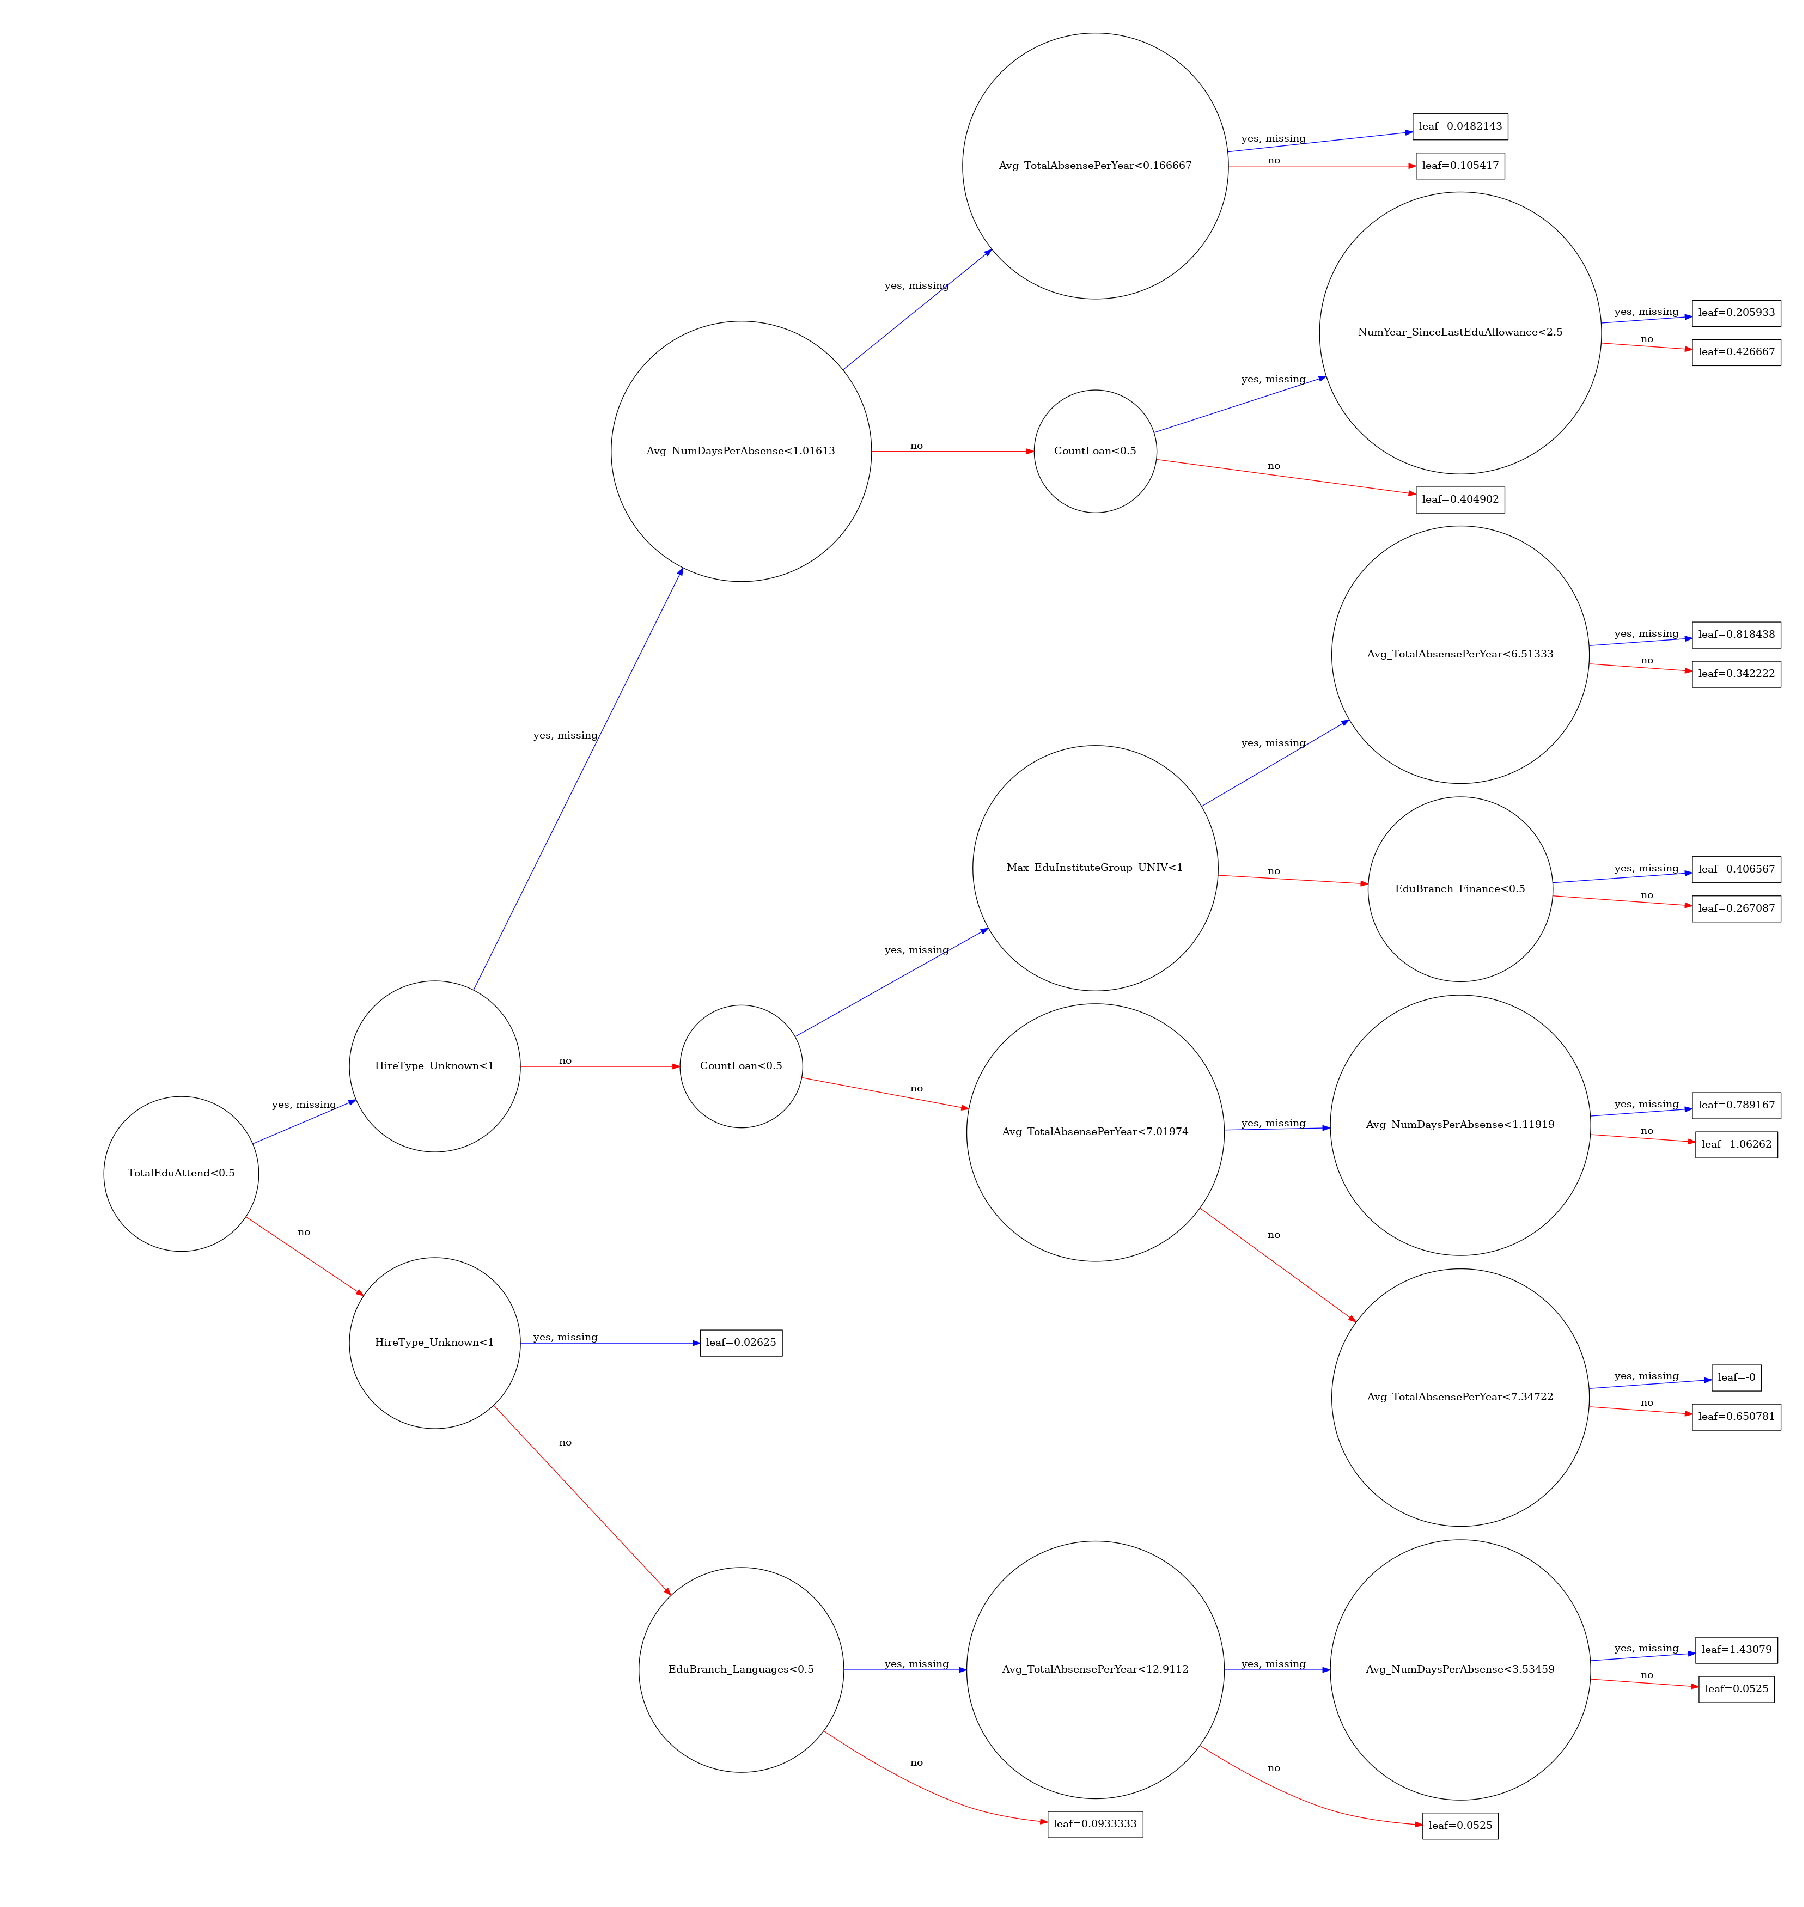

In [22]:
# View tree
# Because graphviz seams to have some resolution problem with pyplot and jupyter, we have to use to trick below to get a readable graph
fig, ax = plt.subplots(figsize=(14, 12), dpi=200)

# plt.figure(figsize=(20,20))
plot_tree(model, num_trees=0, rankdir='LR', ax=ax)
# fig.savefig('regression_tree.png')

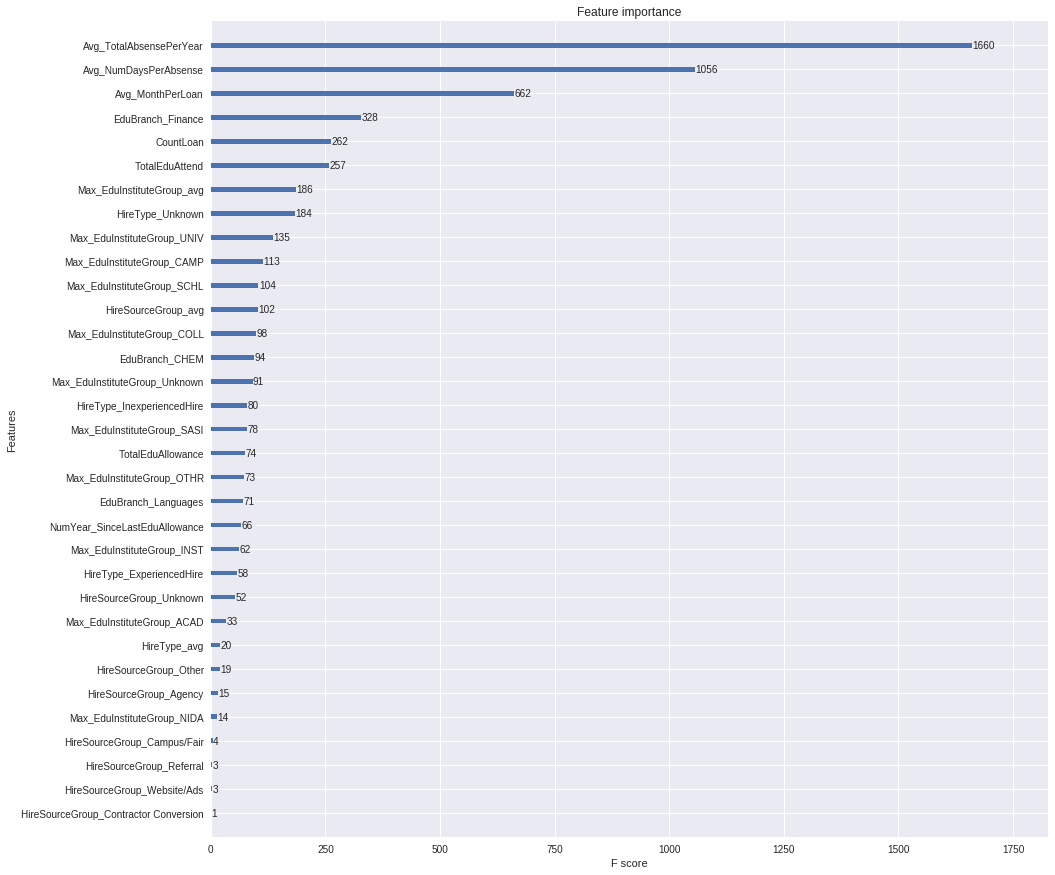

In [23]:
# Plot the importance of each feature
plot_importance(model)